# Assignment 2
## Stochastic and Spatial Models
---
Peterson, Victoria J  
*ID: 15476758* 

Beumer, Wessel T L
*ID: 12640662*

University of Amsterdam  
*Introduction to Computational Science, Block 1, 2024*  

Due: 27 October 2024

---

## Problem 1: Gillespie’s Direct Algorithm and Stochastic Hallmarks


In [63]:
import numpy as np # Numerical Operations
import networkx as nx # Network Analysis
import ndlib.models.ModelConfig as mc # Network Model Configuration
import ndlib.models.epidemics as ep # Epidemic Networks
import dataclasses # Dataclasses
import matplotlib.pyplot as plt # Plotting
from matplotlib import cm # Colormaps
import gc # Garbage Collection

### Classes

In [64]:
"""
SIR Results Dataclass
Variables:
    S_List: list[int] - List of Susceptible over time
    I_List: list[int] - List of Infected over time
    R_List: list[int] - List of Recovered over time
    time: list[float] - List of Time Steps
"""
@dataclasses.dataclass
class Results:
    S_List: list[int] 
    I_List: list[int] 
    R_List: list[int] 
    time: list[float] 

In [65]:
"""
Gillespies Algorithm Events for SIR Model
Variables:
    dX: float - Change in Susceptible
    dY: float - Change in Infected
    dZ: float - Change in Recovered
    rate: float - Rate of Event occurance
"""
class Event:
    dX = 0.0
    dY = 0.0
    dZ = 0.0
    rate = 0.0

class Transmission(Event):
    def __init__(self, beta, X, Y, Z, N):
        self.dX = -1
        self.dY = 1
        self.dZ = 0
        self.rate = beta*X*Y/N

class Births(Event):
    def __init__(self, mu, X, Y, Z, N):
        self.dX = 1
        self.dY = 0
        self.dZ = 0
        self.rate = mu*N

class DeathsX(Event):
    def __init__(self, mu, X, Y, Z, N):
        self.dX = -1
        self.dY = 0.0
        self.dZ = 0.0
        self.rate = mu*X

class DeathsY(Event):
    def __init__(self, mu, X, Y, Z, N):
        self.dX = 0.0
        self.dY = -1
        self.dZ = 0.0
        self.rate = mu*Y

class DeathsZ(Event):
    def __init__(self, mu, X, Y, Z, N):
        self.dX = 0.0
        self.dY = 0.0
        self.dZ = -1
        self.rate = mu*Z

class Recovery(Event):
    def __init__(self, gamma, X, Y, Z, N):
        self.dX = 0.0
        self.dY = -1
        self.dZ = 1
        self.rate = gamma*Y

In [127]:
"""
SIR Model - Gillespies Algorithm Class
Variables:
    X: int - Initial Susceptible
    Y: int - Initial Infected
    Z: int - Initial Recovered
    N: int - Total Population
    beta: float - Transmission Rate
    gamma: float - Recovery Rate
    mu: float - Birth/Death Rate
    results: Results - Results Dataclass
    extinctionTime: float - Time of Extinction
Methods:
    calcEvents: Calculate Event occurance for Gillespies Algorithm
    gillespiesAlgorithm: Gillespies Direct Algorithm
    gillespiesFirstReaction: Gillespies First Reaction Algorithm
    gillespiesSimulation: Gillespies Simulation using Gillespies Direct Algorithm
    getExtinctionTime: Getter for Extinction Time
"""
class SIRModelGillespies:
    def __init__ (self, 
                  X, Y, Z, N, 
                  beta, gamma, mu):
        # Initial Values
        self.X = X
        self.Y = Y
        self.Z = Z
        self.N = N

        # Parameters
        self.beta = beta
        self.gamma = gamma
        self.mu = mu

        # Results
        self.results = Results([], [], [], [])
        self.extinctionTime = float('inf')

    # Calculate Events for Gillespies Algorithm
    def calcEvents(self):
        events = []
        events.append(Transmission(self.beta, self.X, self.Y, self.Z, self.N))
        events.append(Births(self.mu, self.X, self.Y, self.Z, self.N))
        events.append(DeathsX(self.mu, self.X, self.Y, self.Z, self.N))
        events.append(DeathsY(self.mu, self.X, self.Y, self.Z, self.N))
        events.append(DeathsZ(self.mu, self.X, self.Y, self.Z, self.N))
        events.append(Recovery(self.gamma, self.X, self.Y, self.Z, self.N))
        return events

    # Gillespies Direct Algorithm
    def gillespiesAlgorithm(self):
        events = self.calcEvents()
        rateTotal = sum([i.rate for i in events])

        deltaT = -1/rateTotal * np.log(np.random.rand())

        probabilities = np.random.rand() * rateTotal

        upperRate = 0

        for i in events:
            lowerRate = upperRate
            upperRate += i.rate

            if lowerRate < probabilities <= upperRate:
                return i, deltaT
    
    # Gillespies First Reaction Algorithm
    def gillespiesFirstReaction(self):
        events = self.calcEvents()

        minimumDeltaT = float('inf')
        minimumEvent = None

        for i in events:
            if i.rate > 0:
                eventDeltaT = -1/i.rate * np.log(np.random.rand())
                if eventDeltaT < minimumDeltaT:
                    minimumDeltaT = eventDeltaT
                    minimumEvent = i

        return minimumEvent, minimumDeltaT
                
    # Gillespies Simulation using Gillespies Direct Algorithm
    def gillespiesSimulation(self, 
                             finalTime):
        time = 0

        while time < finalTime:
            event, deltaT = self.gillespiesAlgorithm()
            time += deltaT

            self.X += event.dX
            self.Y += event.dY
            self.Z += event.dZ

            self.results.S_List.append(self.X)
            self.results.I_List.append(self.Y)
            self.results.R_List.append(self.Z)
            self.results.time.append(time)

            if (self.Y == 0) & (self.extinctionTime == float('inf')):
                self.extinctionTime = time
    
    # Getters
    @property
    def getExtinctionTime(self):
        return self.extinctionTime

In [128]:
"""
Deterministic SIR Model Class
Inputs:
    X: int - Initial Susceptible
    Y: int - Initial Infected
    Z: int - Initial Recovered
    N: int - Total Population
    beta: float - Transmission Rate
    gamma: float - Recovery Rate
    mu: float - Birth/Death Rate
    timeInterval: float - Time Interval
    timeFinal: int - Final Time
Methods:
    SIRModel: Deterministic SIR Model using Euler's
"""
class SIRModelDeterministic:
    # Constructor
    def __init__ (self, 
                  X, Y, Z, N, 
                  beta, gamma, mu, 
                  timeInterval, timeFinal):
        # Initial Values
        self.X = X
        self.Y = Y
        self.Z = Z
        self.N = N

        # Parameters
        self.beta = beta
        self.gamma = gamma
        self.mu = mu

        # Time Parameters
        self.timeInterval = timeInterval
        self.timeFinal = timeFinal

        # Results
        self.results = Results([], [], [], [])

    # Deterministic SIR Model using Euler's
    def SIRModel(self):
        timeSpan = np.linspace(0, self.timeInterval, self.timeFinal)

        S = np.zeros(self.timeFinal//self.timeInterval)
        I = np.zeros(self.timeFinal//self.timeInterval)
        R = np.zeros(self.timeFinal//self.timeInterval)

        S[0], I[0], R[0] = self.X, self.Y, self.Z
        self.results.time.append(0)

        for t in range(1, len(timeSpan)):
            self.results.time.append(t)

            dSdt = self.mu * (self.N - S[t-1]) - self.beta * S[t-1] * I[t-1] / self.N
            dIdt = self.beta * S[t-1] * I[t-1] / self.N - self.gamma * I[t-1] - self.mu * I[t-1]
            dRdt = self.gamma * I[t-1] - self.mu * R[t-1]

            S[t] = S[t-1] + self.timeInterval * dSdt
            I[t] = I[t-1] + self.timeInterval * dIdt
            R[t] = R[t-1] + self.timeInterval * dRdt


        self.results.S_List = S
        self.results.I_List = I
        self.results.R_List = R


### Model Calculation Functions

In [129]:
"""
Function to calculate the mean, variance 
and standard deviation of a given data array
Input: 
    dataArray: List of floats
"""
def statsCalculation(dataArray):
    mean = np.mean(dataArray)

    sumOfSquares = sum([(i - mean)**2 for i in dataArray])

    variance = sumOfSquares / len(dataArray)

    standardDeviation = np.sqrt(variance)

    return mean, variance, standardDeviation

In [130]:
"""
Function to calculate the covariance of two given data arrays
Input: dataArrayA: List of floats
       dataArrayB: List of floats
"""
def covarianceCalculation(dataArrayA, 
                          dataArrayB):
    meanA = np.mean(dataArrayA)
    meanB = np.mean(dataArrayB)
    
    sampleSize = len(dataArrayA)

    sumProductVariances = sum([(dataArrayA[i] - meanA) * (dataArrayB[i] - meanB) for i in range(len(dataArrayA))])

    covariance = sumProductVariances / sampleSize

    return covariance

In [223]:
"""
Simulate a number of Gillespies SIR Models
with given parameters and initial values
Inputs:
    X0: Initial Susceptible Population
    Y0: Initial Infected Population
    Z0: Initial Recovered Population
    N: Total Population
    beta: Transmission Rate
    gamma: Recovery Rate
    mu: Birth/Death Rate
    time: Time for Simulation
    numRuns: Number of Runs
    saveModels: Option to save models
"""
def simulateNumGillespies(X0, Y0, Z0, N, 
                          beta, gamma, mu, 
                          time, 
                          numRuns, 
                          saveModels=True):
    
    models = []

    covarianceOfRunsSI = 0.0

    meanOfRuns = [0.0, 0.0, 0.0]
    varianceOfRuns = [0.0, 0.0, 0.0]
    stdDevOfRuns = [0.0, 0.0, 0.0]

    numExtinctions = 0
    totalExtinctionTime = 0

    # Iterate through number of runs
    for i in range(numRuns):
        # Simulate Gillespies for current parameters
        model = SIRModelGillespies(X0, Y0, Z0, N, 
                                   beta, gamma, mu)
        
        model.gillespiesSimulation(time)


        # Calculate mean, variance, and standard deviation for each list
        meanS, varianceS, standardDeviationS = statsCalculation(model.results.S_List)
        meanI, varianceI, standardDeviationI = statsCalculation(model.results.I_List)
        meanR, varianceR, standardDeviationR = statsCalculation(model.results.R_List)

        meanOfRuns[0] += meanS
        meanOfRuns[1] += meanI
        meanOfRuns[2] += meanR

        varianceOfRuns[0] += varianceS
        varianceOfRuns[1] += varianceI
        varianceOfRuns[2] += varianceR

        stdDevOfRuns[0] += standardDeviationS
        stdDevOfRuns[1] += standardDeviationI
        stdDevOfRuns[2] += standardDeviationR


        # Calculate covariance of SI
        covarianceOfRunsSI += covarianceCalculation(model.results.S_List, 
                                                    model.results.I_List)
        covarianceOfRunsSI /= numRuns

        # Check if Extinction has occurred
        if model.getExtinctionTime < time: 
            numExtinctions += 1
            totalExtinctionTime += model.getExtinctionTime


        # Save Model in an array if required by saveModels flag
        if saveModels:
            models.append(model)
        else:
            del model
    
    # Calculate Extinction data for the number of runs
    proportionExtinctions = numExtinctions / numRuns
    if numExtinctions > 0: 
        meanExtinctionTime = totalExtinctionTime / numExtinctions
    else:
        meanExtinctionTime = None


    # Calculate the averaged mean, variance, and standard deviation for each S, I, R population
    for i in range(3):
        meanOfRuns[i] /= numRuns
        varianceOfRuns[i] /= numRuns
        stdDevOfRuns[i] /= numRuns

    return (models, 
            meanOfRuns, 
            varianceOfRuns, 
            stdDevOfRuns, 
            covarianceOfRunsSI, 
            meanExtinctionTime, 
            proportionExtinctions)
"""
Returns:
    models: List of models if saveModels flag is True
    meanOfRuns: List of mean values for S, I, R populations
    varianceOfRuns: List of variance values for S, I, R populations
    stdDevOfRuns: List of standard deviation values for S, I, R populations
    covarianceOfRunsSI: Covariance of S, I populations
    meanExtinctionTime: Mean Extinction Time for the number of runs
    proportionExtinctions: Proportion of Extinctions for the number of runs
"""

'\nReturns:\n    models: List of models if saveModels flag is True\n    meanOfRuns: List of mean values for S, I, R populations\n    varianceOfRuns: List of variance values for S, I, R populations\n    stdDevOfRuns: List of standard deviation values for S, I, R populations\n    covarianceOfRunsSI: Covariance of S, I populations\n    meanExtinctionTime: Mean Extinction Time for the number of runs\n    proportionExtinctions: Proportion of Extinctions for the number of runs\n'

In [224]:
"""
Simulate a Deterministic SIR Model
with given parameters and initial values
Inputs:
    X0: Initial Susceptible Population
    Y0: Initial Infected Population
    Z0: Initial Recovered Population
    N: Total Population
    beta: Transmission Rate
    gamma: Recovery Rate
    mu: Birth/Death Rate
    timeInterval: Time Interval
    timeFinal: Final Time
"""
def simulateDeterministicModel(X0, Y0, Z0, N, 
                               beta, gamma, mu, 
                               timeInterval, timeFinal):
    meanSIR = [0.0, 0.0, 0.0]
    varSIR = [0.0, 0.0, 0.0]
    stdDevSIR = [0.0, 0.0, 0.0]
    
    model = SIRModelDeterministic(X0, Y0, Z0, N, 
                                  beta, gamma, mu, 
                                  timeInterval, timeFinal)

    model.SIRModel()

    meanS, varS, stdDevS = statsCalculation(model.results.S_List)
    meanI, varI, stdDevI = statsCalculation(model.results.I_List)
    meanR, varR, stdDevR = statsCalculation(model.results.R_List)

    covarianceSI = covarianceCalculation(model.results.S_List, model.results.I_List)

    meanSIR[0] = meanS
    meanSIR[1] = meanI
    meanSIR[2] = meanR

    varSIR[0] = varS
    varSIR[1] = varI
    varSIR[2] = varR

    stdDevSIR[0] = stdDevS
    stdDevSIR[1] = stdDevI
    stdDevSIR[2] = stdDevR

    return (model,
            meanSIR,
            varSIR,
            stdDevSIR,
            covarianceSI)
"""
Results:
    model: Deterministic SIR Model
    meanSIR: Mean values for S, I, R populations
    varSIR: Variance values for S, I, R populations
    stdDevSIR: Standard Deviation values for S, I, R populations
    covarianceSI: Covariance of S, I populations
"""

'\nResults:\n    model: Deterministic SIR Model\n    meanSIR: Mean values for S, I, R populations\n    varSIR: Variance values for S, I, R populations\n    stdDevSIR: Standard Deviation values for S, I, R populations\n    covarianceSI: Covariance of S, I populations\n'

### Model Plotting Functions

In [225]:
"""
Plot in 2D a statistic for a given parameter range
for both deterministic and stochastic models
Inputs:
    deterministicStat: List of deterministic statistics for S, I, R populations
    stochasticStat: List of stochastic statistics for S, I, R populations
    parameterValues: List of parameter values of a given range
    title: Title of the plot
    xlabel: Label for x-axis (Parameter Range)
    ylabel: Label for y-axis (Statistic Values)
"""
def plotStatisticsSIR(deterministicStat,
                      stochasticStat, 
                      parameterValues, 
                      title, xlabel, ylabel):
    statS = [stochasticStat[b][0] for b in parameterValues]
    statI = [stochasticStat[b][1] for b in parameterValues]
    statR = [stochasticStat[b][2] for b in parameterValues]

    detStats = [deterministicStat[b][0] for b in parameterValues]
    detStatI = [deterministicStat[b][1] for b in parameterValues]
    detStatR = [deterministicStat[b][2] for b in parameterValues]

    plt.figure()

    plt.plot(parameterValues, statS, 'r', label = "S")
    plt.plot(parameterValues, statI, 'b', label = "I")
    plt.plot(parameterValues, statR, 'g', label = "R")

    plt.plot(parameterValues, detStats, 'r--', label = "S Deterministic")
    plt.plot(parameterValues, detStatI, 'b--', label = "I Deterministic")
    plt.plot(parameterValues, detStatR, 'g--', label = "R Deterministic")

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

    plt.show()

In [226]:
"""
Plots in 2D a deterministic model on top of a number of
stochastic models for a given single parameter value
Inputs:
    deterministicModel: Deterministic SIR Model
    stochasticModels: List of Stochastic SIR Models
    parameterValue: Parameter Value
    title: Title of the plot
    xlabel: Label for x-axis (Time)
    ylabel: Label for y-axis (S, I, R populations)
"""
def plotSIRSimulations(deterministicModel, 
                       stochasticModels, 
                       parameterValue, 
                       title, xlabel, ylabel):
    detModelResults = deterministicModel[parameterValue].results

    plt.figure()

    for i in range(len(stochasticModels[parameterValue])):
        stocModelResults = stochasticModels[parameterValue][i].results
        plt.plot(stocModelResults.time, stocModelResults.S_List, alpha=0.1, color = 'grey')
        plt.plot(stocModelResults.time, stocModelResults.I_List, alpha=0.1, color = 'grey')
        plt.plot(stocModelResults.time, stocModelResults.R_List, alpha=0.1, color = 'grey')

    plt.plot(detModelResults.time, detModelResults.S_List, 'r', label = "S")
    plt.plot(detModelResults.time, detModelResults.I_List, 'b', label = "I")
    plt.plot(detModelResults.time, detModelResults.R_List, 'g', label = "R")

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

    plt.show()

In [227]:
"""
Plot in 2D the covariance of two populations for a given parameter range
Inputs:
    dCovariance: List of Covariance values for two populations
    covariance: List of Covariance values for two populations
    parameterValuesRange: List of parameter values of a given range
    title: Title of the plot
    xlabel: Label for x-axis (Parameter Range)
    ylabel: Label for y-axis (Covariance Values)
"""
def plotCovarianceSI(dCovariance, 
                     covariance, 
                     parameterValuesRange, 
                     title, xlabel, ylabel):
    dCovarianceValuesSI = [dCovariance[g] for g in parameterValuesRange]
    covarianceValuesGammaSI = [covariance[g] for g in parameterValuesRange]

    plt.figure()

    plt.plot(parameterValuesRange, covarianceValuesGammaSI, 'r', label = "SI Covariance")
    plt.plot(parameterValuesRange, dCovarianceValuesSI, 'r--', label = "SI Covariance Deterministic")

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

    plt.show()

In [228]:
"""
Plot a 3D Mesh of a statistic over two parameter ranges
Input:
    paramValues1: List of parameter values for first range
    paramValues2: List of parameter values for second range
    zValues: List of statistic values
    xlabel: Label for x-axis (First Parameter Range)
    ylabel: Label for y-axis (Second Parameter Range)
    zlabel: Label for z-axis (Statistic Values)
    title: Title of the plot
    elev: Elevation of the plot (Default 40)
    azim: Azimuth of the plot (Default 50)
    r0Values: List of R0 values (Default None)
"""
def plot3DMesh(paramValues1, 
                paramValues2, 
                zValues, 
                xlabel, 
                ylabel, 
                zlabel, 
                title, 
                elev=40, 
                azim=50, 
                r0Values=None):
    npParamValues1 = np.array(paramValues1)
    npParamValues2 = np.array(paramValues2)
    npZValues = np.array(zValues)

    uniqueParamValues1 = np.unique(npParamValues1)
    uniqueParamValues2 = np.unique(npParamValues2)
    
    paramMesh1, paramMesh2 = np.meshgrid(uniqueParamValues1, uniqueParamValues2)

    zMesh = npZValues.reshape(len(uniqueParamValues2), len(uniqueParamValues1))


    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')

    if r0Values is not None:
        npR0Values = np.array(r0Values)
        r0Mesh = npR0Values.reshape(len(uniqueParamValues2), len(uniqueParamValues1))

        norm = plt.Normalize(r0Mesh.min(), r0Mesh.max())
        colors = cm.Greens(norm(r0Mesh))

        ax.plot_surface(paramMesh1, paramMesh2, zMesh, facecolors=colors, edgecolor='grey', shade=False, linewidth=0.25)

        mappable = cm.ScalarMappable(norm=norm, cmap=cm.Greens)
        mappable.set_array(r0Mesh)
        fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=25, label='R0 Values')
    else:
        plotSurface = ax.plot_surface(paramMesh1, paramMesh2, zMesh, cmap='viridis')

        fig.colorbar(plotSurface, ax=ax, shrink=0.5, aspect=20)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_title(title)
    ax.view_init(elev=elev, azim=azim)

    plt.show()

### Statistical Features of a Range of Infection Rates Beta

In [229]:
X0 = 990
Y0 = 10
Z0 = 0
N = X0 + Y0 + Z0
beta = 0.25
gamma = 0.05
mu = 0.005

In [230]:
time = 1000
timeInterval = 1

In [231]:
numRunsBeta = 50

In [232]:
betaMax = 1
betaSteps = 40
betaMin = betaMax / betaSteps
betaValues = np.linspace(betaMin, betaMax, betaSteps)

In [233]:
betaModels = {}

varBeta = {}
meansBeta = {}
stdDevBeta = {}
covBetaSI = {}

extTimeBeta = {} 
extPropBeta = {} 

for b in betaValues:
    # Simulate Gillespies for current beta value
    (betaModels[b], 
     meansBeta[b], 
     varBeta[b], 
     stdDevBeta[b], 
     covBetaSI[b], 
     extTimeBeta[b], 
     extPropBeta[b]) = simulateNumGillespies(X0, Y0, Z0, N, 
                                             b, 
                                             gamma, mu, 
                                             time, 
                                             numRunsBeta)

In [234]:
dAllModelsBeta = {}
dMeansBeta = {}
dVariancesBeta = {}
dStandardDeviationsBeta = {}
dCovarianceSI = {}

# Simulate Deterministic SIR Model for range of Beta
for b in betaValues:
    (dAllModelsBeta[b],
     dMeansBeta[b],
     dVariancesBeta[b],
     dStandardDeviationsBeta[b],
     dCovarianceSI[b]) = simulateDeterministicModel(X0, Y0, Z0, N,
                                                      b, gamma, mu,
                                                      timeInterval, time)

#### Plot of Deterministic Model over a Number of Gillespie's Simulations

In [235]:
PLOTTED_BETA_1 = 0.3

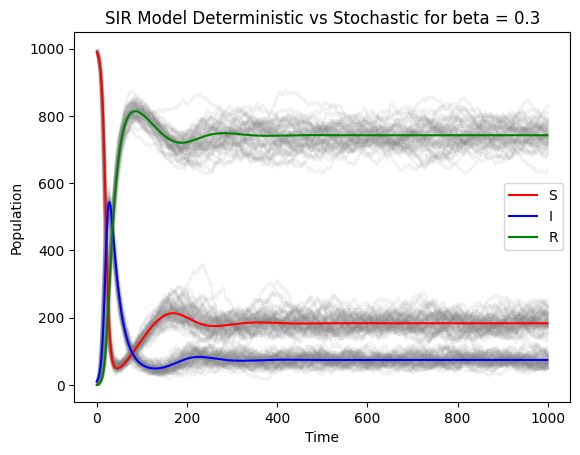

In [236]:
plotSIRSimulations(dAllModelsBeta, 
                   betaModels, 
                   PLOTTED_BETA_1, 
                   "SIR Model Deterministic vs Stochastic for beta = " 
                   + str(PLOTTED_BETA_1), 
                   "Time", 
                   "Population")

In [237]:
PLOTTED_BETA_2 = 0.125

C:\Users\Victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


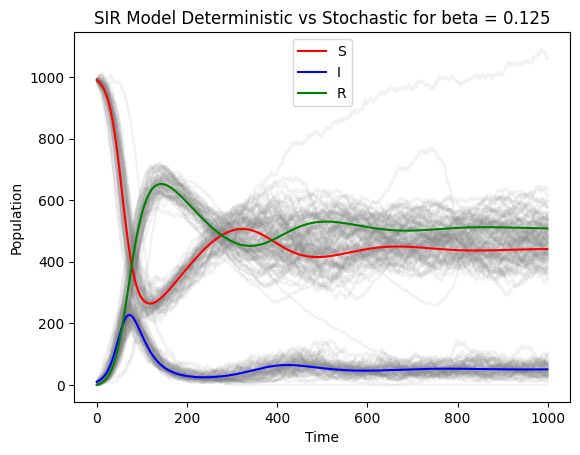

In [238]:
plotSIRSimulations(dAllModelsBeta, 
                   betaModels, 
                   PLOTTED_BETA_2, 
                   "SIR Model Deterministic vs Stochastic for beta = " 
                   + str(PLOTTED_BETA_2), 
                   "Time", 
                   "Population")

#### Mean value of the average of a Number of Gillespie's Simulations for a range of Beta

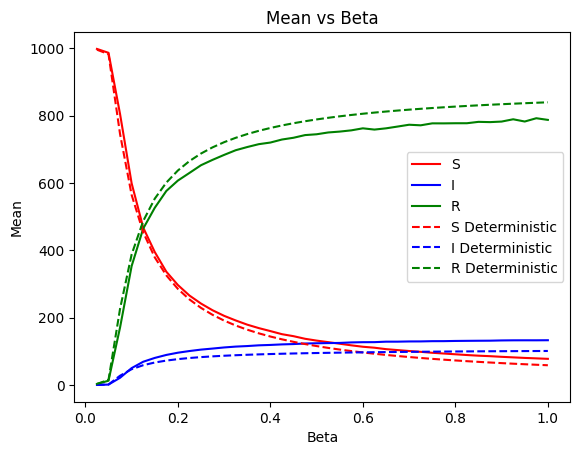

In [239]:
plotStatisticsSIR(dMeansBeta, 
                  meansBeta, 
                  betaValues, 
                  "Mean vs Beta", 
                  "Beta", 
                  "Mean")

#### Standard Deviation value of the average of a Number of Gillespie's Simulations for a Range of Beta

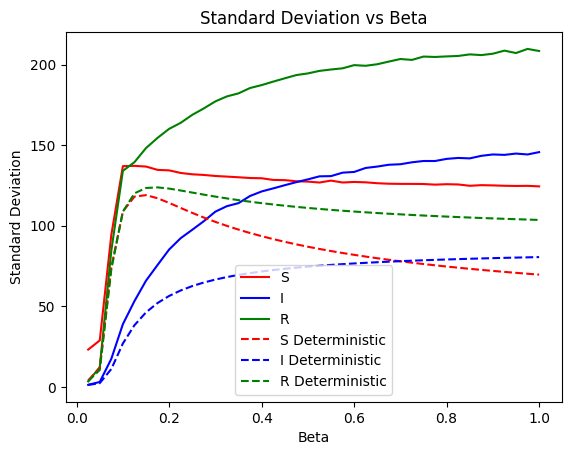

In [240]:
plotStatisticsSIR(dStandardDeviationsBeta, 
                  stdDevBeta, 
                  betaValues, 
                  "Standard Deviation vs Beta", 
                  "Beta", 
                  "Standard Deviation")

#### Covariance value of the average of a Number of Gillespie's Simulations for a range of Beta

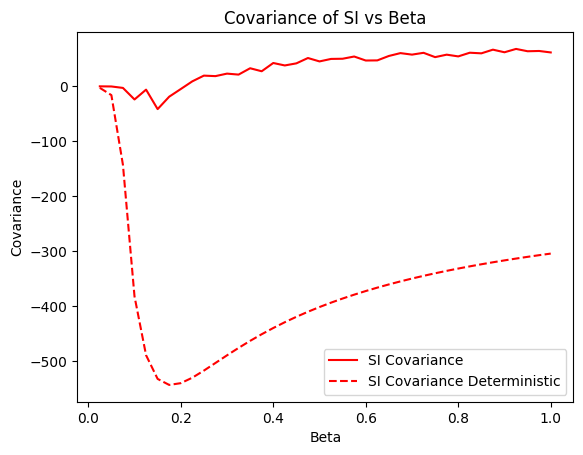

In [241]:
plotCovarianceSI(dCovarianceSI, 
                 covBetaSI, 
                 betaValues, 
                 "Covariance of SI vs Beta", 
                 "Beta", 
                 "Covariance")

#### Average Extinction time for a Number of Gillespie's Simulations for a range of Beta

C:\Users\Victo\AppData\Local\Temp\ipykernel_24592\964498347.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


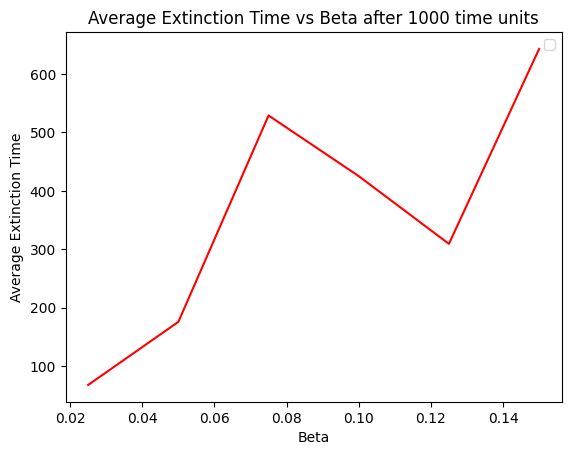

In [242]:
plt.figure()

plt.plot(extTimeBeta.keys(), extTimeBeta.values(), 'r')

plt.xlabel("Beta")
plt.ylabel("Average Extinction Time")
plt.title("Average Extinction Time vs Beta after " 
          + str(time) 
          + " time units")

plt.legend()
plt.show()

#### Proportion of Extinctions for a Number of Gillespie's Simulations for a range of Beta

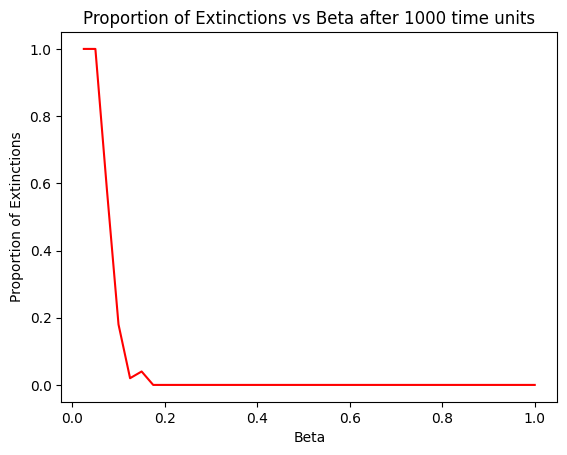

In [243]:
plt.figure()

plt.plot(extPropBeta.keys(), extPropBeta.values(), 'r')

plt.xlabel("Beta")
plt.ylabel("Proportion of Extinctions")
plt.title("Proportion of Extinctions vs Beta after " 
          + str(time) 
          + " time units")

plt.show()

### Statistical Features of a Range of Recovery Rates Gamma

In [244]:
X0 = 990
Y0 = 10
Z0 = 0
N = X0 + Y0 + Z0
beta = 0.25
gamma = 0.05
mu = 0.005

In [245]:
time = 1000
timeInterval = 1

In [246]:
numRunsGamma = 50

In [247]:
gammaMax = 0.6
gammaSteps = 40
gammaMin = gammaMax / gammaSteps
gammaValues = np.linspace(gammaMin, gammaMax, gammaSteps)

In [248]:
gammaModels = {}

varGamma = {}
meansGamma = {}
stdDevGamma = {}
covGammaSI = {}

extTimeGamma = {} 
extPropGamma = {} 

for g in gammaValues:
    # Simulate Gillespies for current gamma value
    (gammaModels[g], 
     meansGamma[g], 
     varGamma[g], 
     stdDevGamma[g], 
     covGammaSI[g], 
     extTimeGamma[g], 
     extPropGamma[g]) = simulateNumGillespies(X0, Y0, Z0, N, 
                                             beta, 
                                             g, 
                                             mu, 
                                             time, 
                                             numRunsGamma)

In [249]:
dAllModelsGamma = {}
dMeansGamma = {}
dVariancesGamma = {}
dStandardDeviationsGamma = {}
dCovarianceGammaSI = {}

for g in gammaValues:

    (dAllModelsGamma[g],
     dMeansGamma[g],
     dVariancesGamma[g],
     dStandardDeviationsGamma[g],
     dCovarianceGammaSI[g]) = simulateDeterministicModel(X0, Y0, Z0, N,
                                                      beta, g, mu,
                                                      timeInterval, time)

#### Plot of Deterministic Model over a Number of Gillespie's Simulations

In [250]:
PLOTTED_GAMMA_1 = 0.105

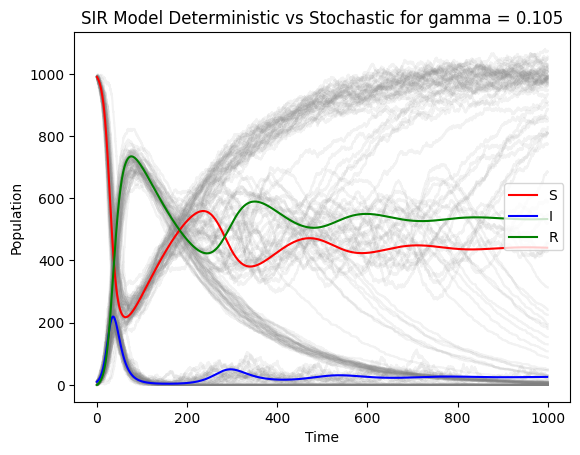

In [251]:
plotSIRSimulations(dAllModelsGamma, 
                   gammaModels, 
                   PLOTTED_GAMMA_1, 
                   "SIR Model Deterministic vs Stochastic for gamma = " 
                   + str(PLOTTED_GAMMA_1), 
                   "Time", 
                   "Population")

In [252]:
PLOTTED_GAMMA_2 = 0.045

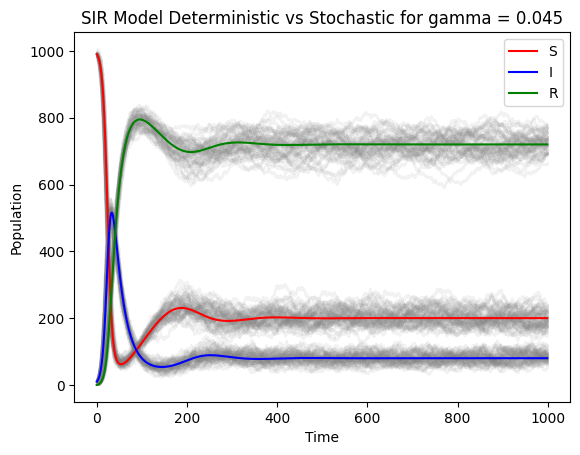

In [253]:
plotSIRSimulations(dAllModelsGamma, 
                   gammaModels, 
                   PLOTTED_GAMMA_2, 
                   "SIR Model Deterministic vs Stochastic for gamma = " 
                   + str(PLOTTED_GAMMA_2), 
                   "Time", 
                   "Population")

#### Mean value of the average of a Number of Gillespie's Simulations for a range of Gamma

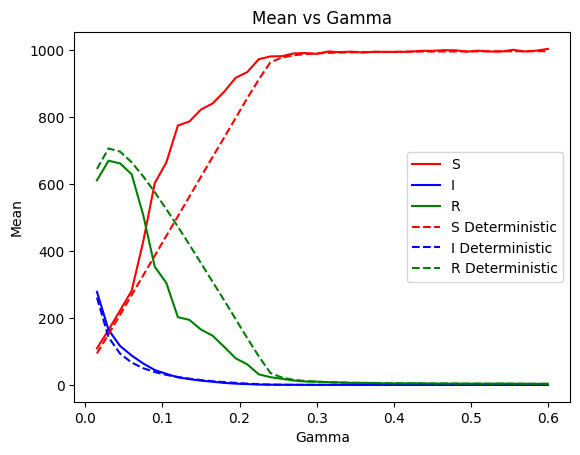

In [254]:
plotStatisticsSIR(dMeansGamma, 
                  meansGamma, 
                  gammaValues, 
                  "Mean vs Gamma", 
                  "Gamma", 
                  "Mean")

#### Standard Deviation value of the average of a Number of Gillespie's Simulations for a Range of Gamma

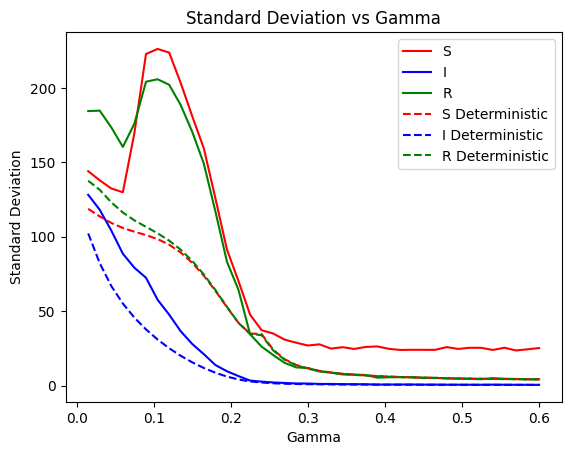

In [255]:
plotStatisticsSIR(dStandardDeviationsGamma, 
                  stdDevGamma, 
                  gammaValues, 
                  "Standard Deviation vs Gamma", 
                  "Gamma", 
                  "Standard Deviation")

#### Covariance value of the average of a Number of Gillespie's Simulations for a range of Gamma

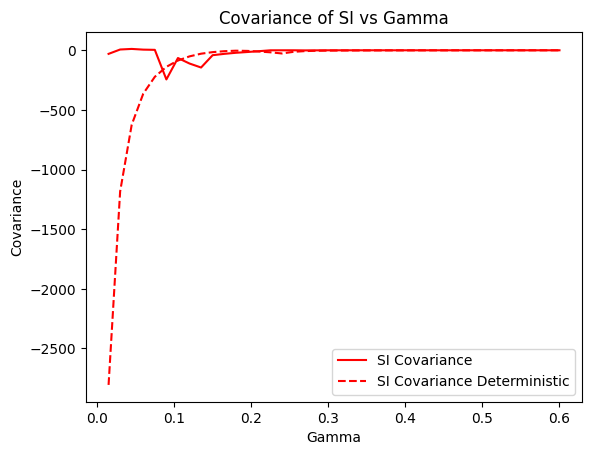

In [256]:
plotCovarianceSI(dCovarianceGammaSI, 
                 covGammaSI, 
                 gammaValues, 
                 "Covariance of SI vs Gamma", 
                 "Gamma", 
                 "Covariance")

#### Average Extinction time for a Number of Gillespie's Simulations for a range of Gamma

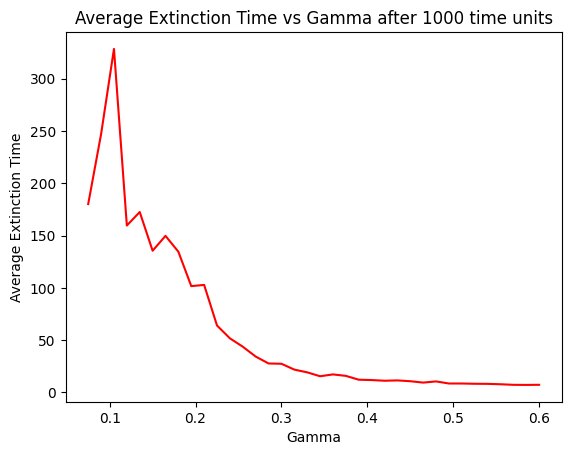

In [257]:
plt.figure()

plt.plot(extTimeGamma.keys(), extTimeGamma.values(), 'r')

plt.xlabel("Gamma")
plt.ylabel("Average Extinction Time")
plt.title("Average Extinction Time vs Gamma after " 
          + str(time) 
          + " time units")

plt.show()

#### Proportion of Extinctions for a Number of Gillespie's Simulations for a range of Gamma

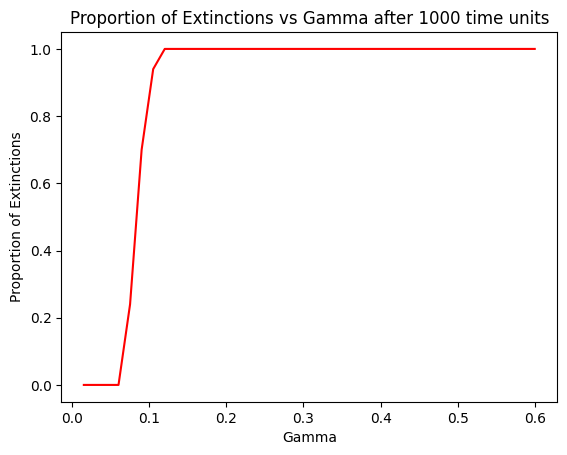

In [258]:
plt.figure()

plt.plot(extPropGamma.keys(), extPropGamma.values(), 'r')

plt.xlabel("Gamma")
plt.ylabel("Proportion of Extinctions")
plt.title("Proportion of Extinctions vs Gamma after " 
          + str(time) 
          + " time units")

plt.show()

### Statistical Features of a Range of Gamma and Beta Values

In [259]:
X0 = 990
Y0 = 10
Z0 = 0
N = X0 + Y0 + Z0
beta = 0.25
gamma = 0.05
mu = 0.005

In [260]:
time = 1000
timeInterval = 1

In [261]:
numRunsBetaGamma = 50

In [262]:
gamma3DMax = 0.6
gamma3DSteps = 20
gamma3DMin = 0.1
gamma3DValues = np.linspace(gamma3DMin, gamma3DMax, gamma3DSteps)

In [263]:
beta3DMax = 1.0
beta3DSteps = 20
beta3DMin = beta3DMax / beta3DSteps
beta3DValues = np.linspace(beta3DMin, beta3DMax, beta3DSteps)

In [264]:
saveModels = False

In [265]:
betaGammaModels = {}

varBetaGamma = {}
meansBetaGamma = {}
stdDevBetaGamma = {}
covBetaGammaSI = {}

extTimeBetaGamma = {} 
extPropBetaGamma = {} 

for b in beta3DValues:
    for g in gamma3DValues:
        # Simulate Gillespies for current beta and gamma value
        (betaGammaModels[b, g], 
        meansBetaGamma[b, g], 
        varBetaGamma[b, g], 
        stdDevBetaGamma[b, g], 
        covBetaGammaSI[b, g], 
        extTimeBetaGamma[b, g], 
        extPropBetaGamma[b, g]) = simulateNumGillespies(X0, Y0, Z0, N, 
                                                    b, 
                                                    g, 
                                                    mu, 
                                                    time, 
                                                    numRunsBetaGamma,
                                                    saveModels)

In [266]:
r0Flat = []
stdDevFlatS = []
stdDevFlatI = []
stdDevFlatR = []

covarianceFlatSI = []

extinctionTimeFlat = []
extinctionProportionFlat = []

for g in gamma3DValues:
    for b in beta3DValues:
        r0 = b / (g+mu)
        r0Flat.append(r0)

        stdS, stdI, stdR = stdDevBetaGamma[b, g]

        stdDevFlatS.append(stdS)
        stdDevFlatI.append(stdI)
        stdDevFlatR.append(stdR)

        covarianceFlatSI.append(covBetaGammaSI[b, g])

        extinctionTimeFlat.append(extTimeBetaGamma[b, g])
        extinctionProportionFlat.append(extPropBetaGamma[b, g])

#### Standard Deviation value of the average of a Number of Gillespie's Simulations for a Range of Gamma and Beta

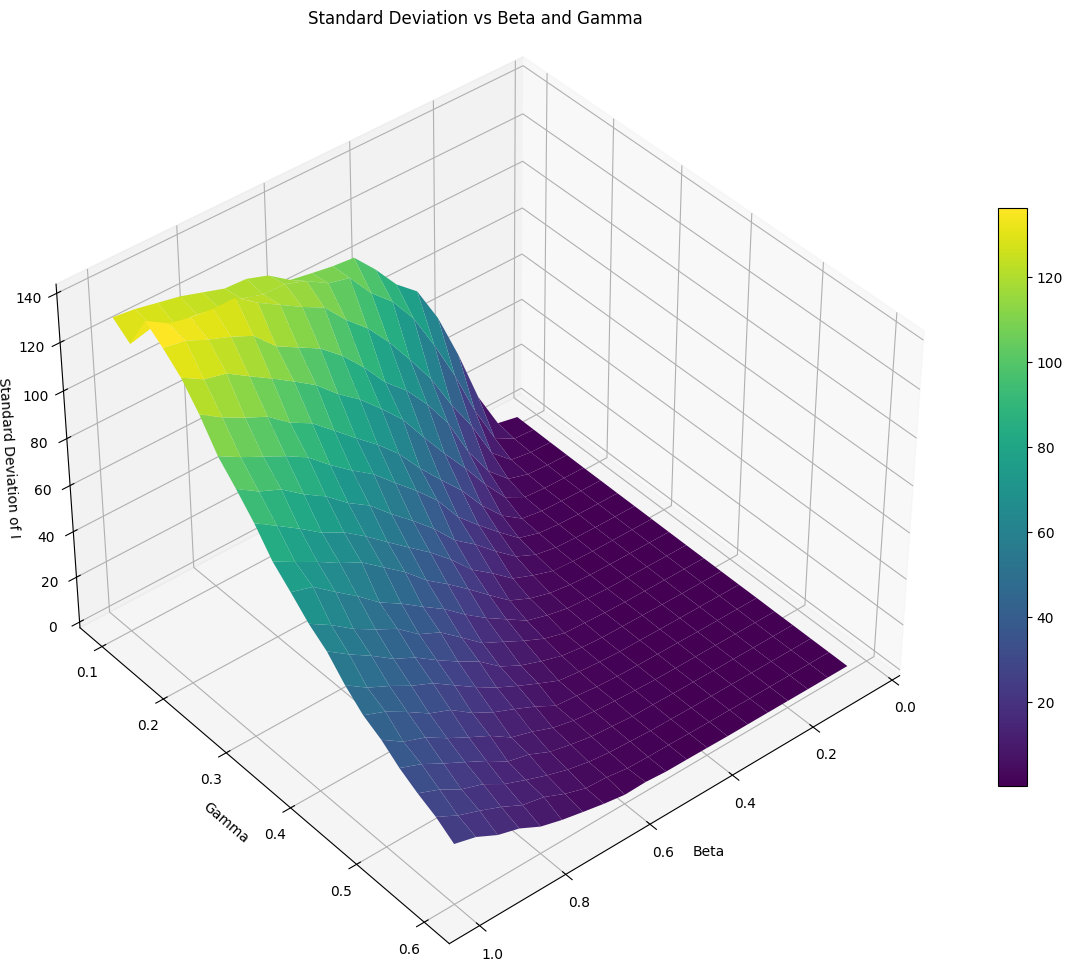

In [267]:
plot3DMesh(beta3DValues,
            gamma3DValues,
            stdDevFlatI, 
            "Beta", 
            "Gamma", 
            "Standard Deviation of I", 
            "Standard Deviation vs Beta and Gamma")

#### Standard Deviation value of the average of a Number of Gillespie's Simulations for a Range of Gamma and Beta with Basic Reproductive Rate color range

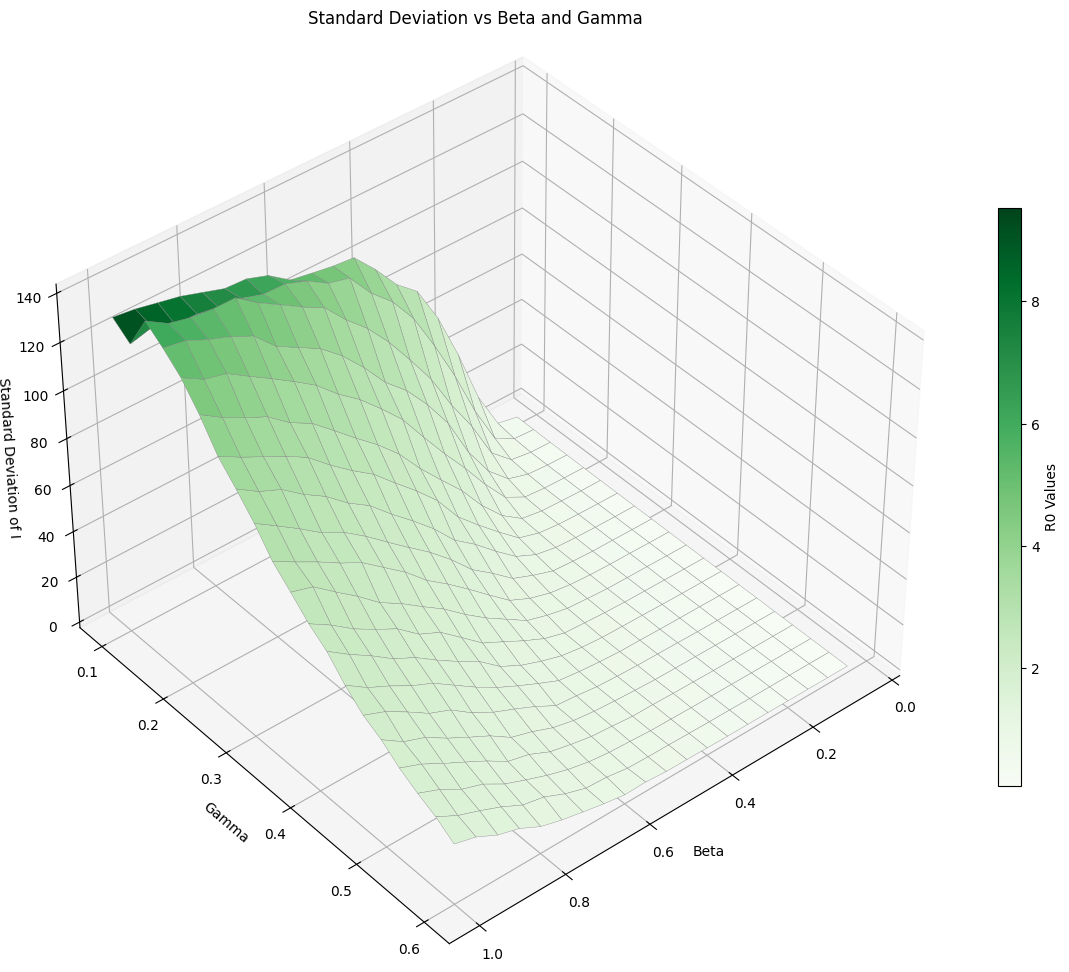

In [268]:
plot3DMesh(beta3DValues,
            gamma3DValues,
            stdDevFlatI, 
            "Beta", 
            "Gamma", 
            "Standard Deviation of I", 
            "Standard Deviation vs Beta and Gamma",
            40, 50,
            r0Flat)

#### Basic Reproductive Rate of the average of a Number of Gillespie's Simulations for a Range of Gamma and Beta

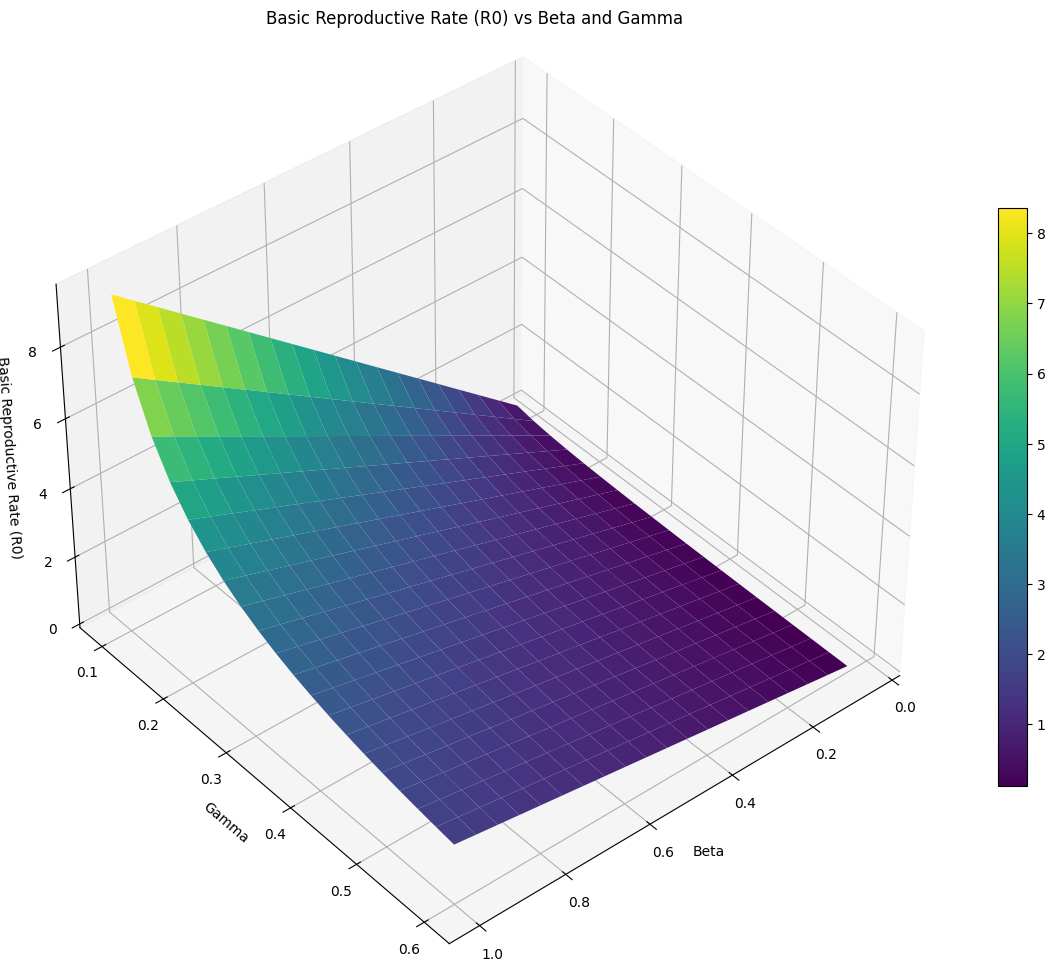

In [269]:
plot3DMesh(beta3DValues,
            gamma3DValues, 
            r0Flat, 
            "Beta", 
            "Gamma", 
            "Basic Reproductive Rate (R0)", 
            "Basic Reproductive Rate (R0) vs Beta and Gamma")

#### Covariance value of the average of a Number of Gillespie's Simulations for a Range of Gamma and Beta

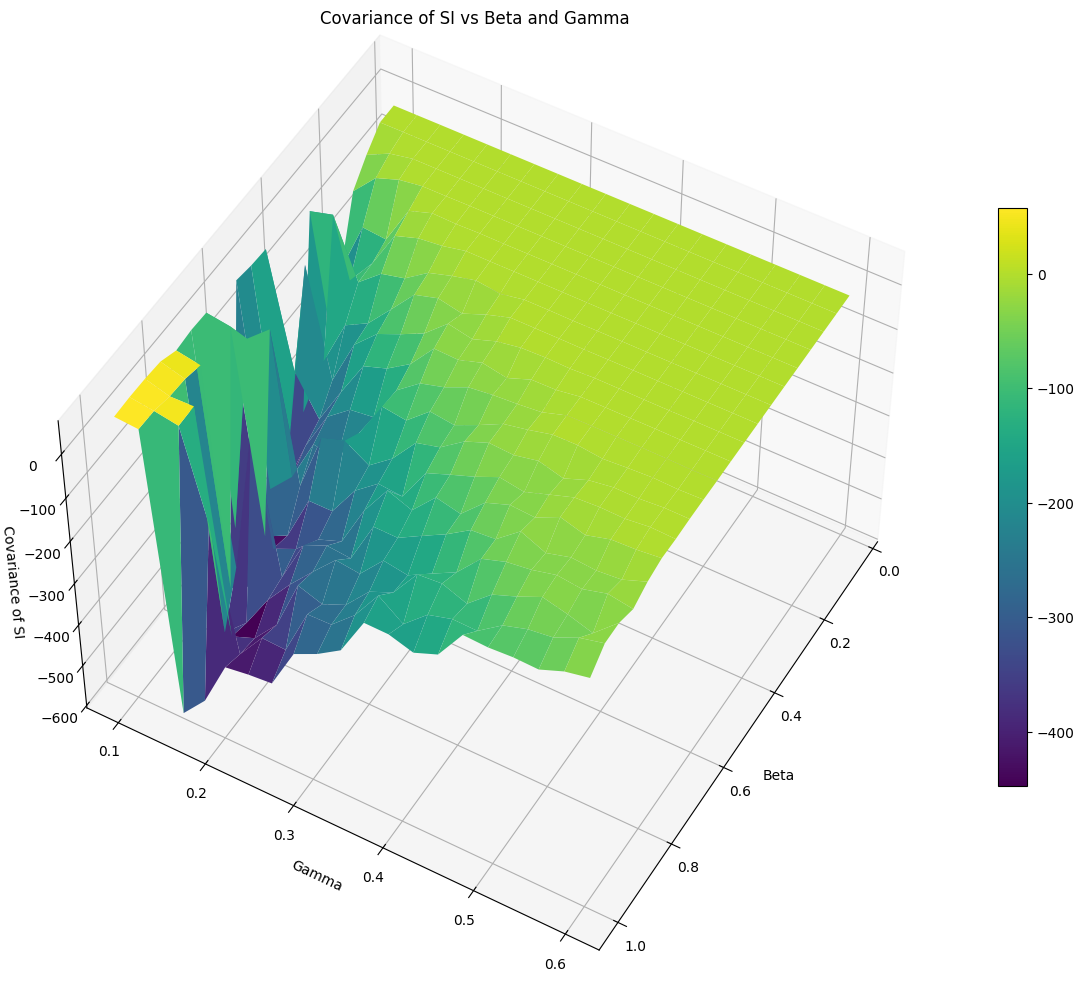

In [270]:
plot3DMesh(beta3DValues,
            gamma3DValues,
            covarianceFlatSI, 
            "Beta", 
            "Gamma", 
            "Covariance of SI", 
            "Covariance of SI vs Beta and Gamma", 
            50, 30)

#### Covariance value of the average of a Number of Gillespie's Simulations for a Range of Gamma and Beta with Basic Reproductive Rate color range

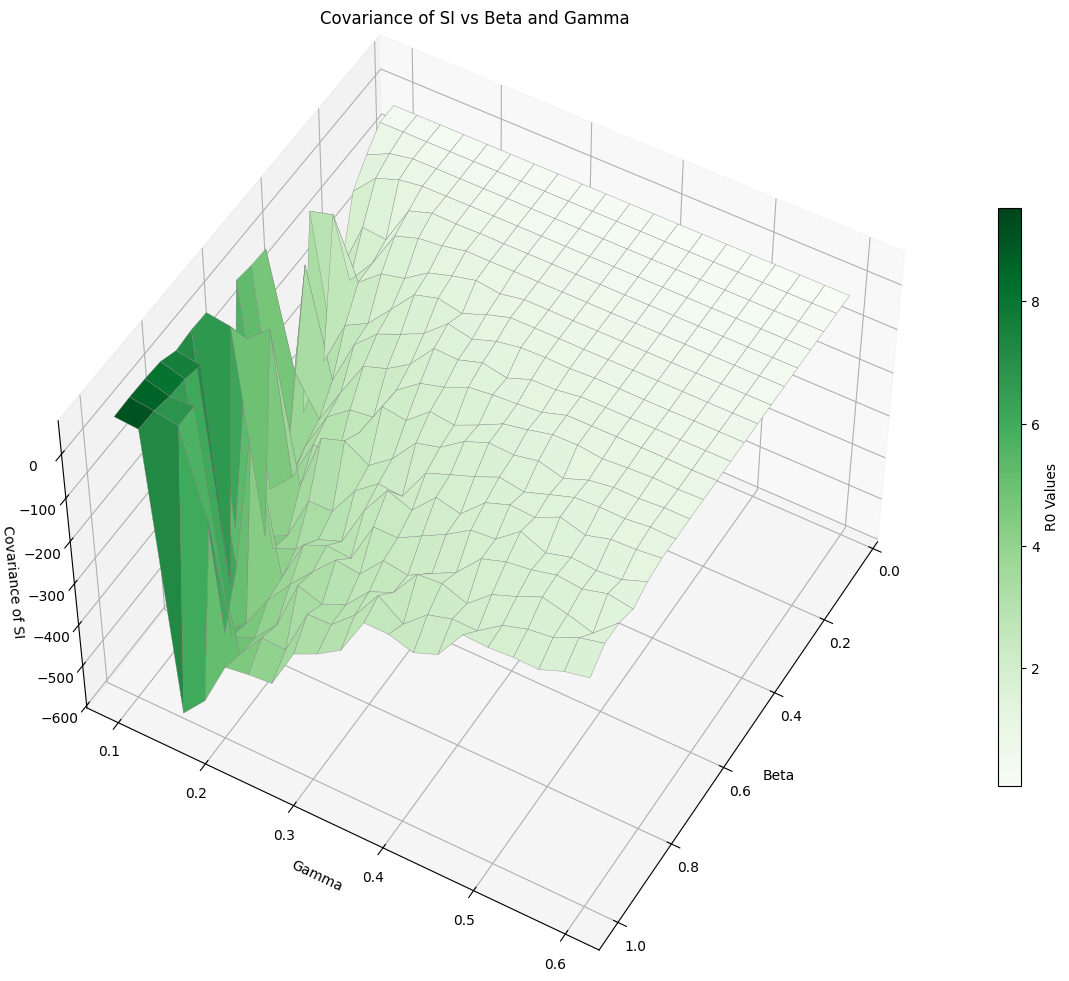

In [271]:
plot3DMesh(beta3DValues,
            gamma3DValues,
            covarianceFlatSI, 
            "Beta", 
            "Gamma", 
            "Covariance of SI", 
            "Covariance of SI vs Beta and Gamma", 
            50, 30,
            r0Flat)

#### Basic Reproductive Rate of the average of a Number of Gillespie's Simulations for a Range of Gamma and Beta

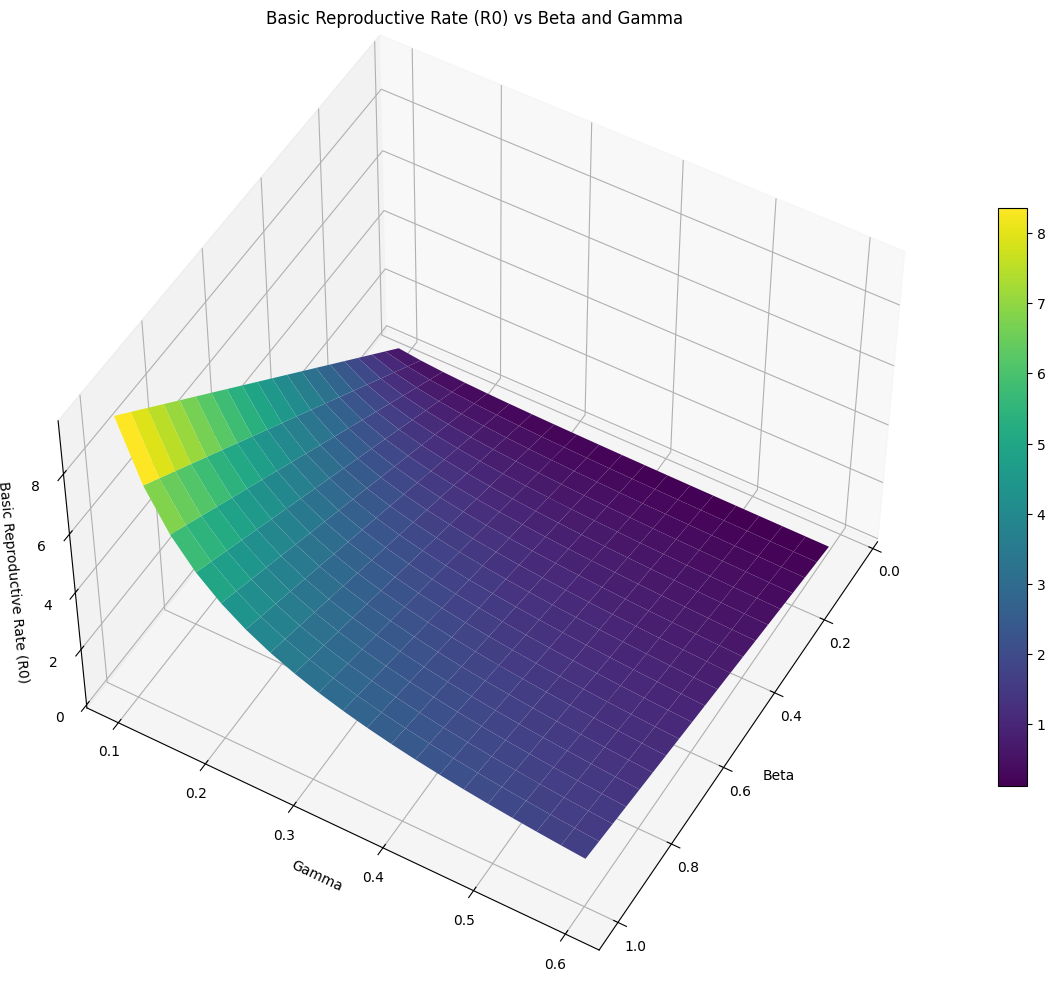

In [272]:
plot3DMesh(beta3DValues,
            gamma3DValues, 
            r0Flat, 
            "Beta", 
            "Gamma", 
            "Basic Reproductive Rate (R0)", 
            "Basic Reproductive Rate (R0) vs Beta and Gamma",
            50, 30)

#### Average Extinction Time of the average of a Number of Gillespie's Simulations for a Range of Gamma and Beta

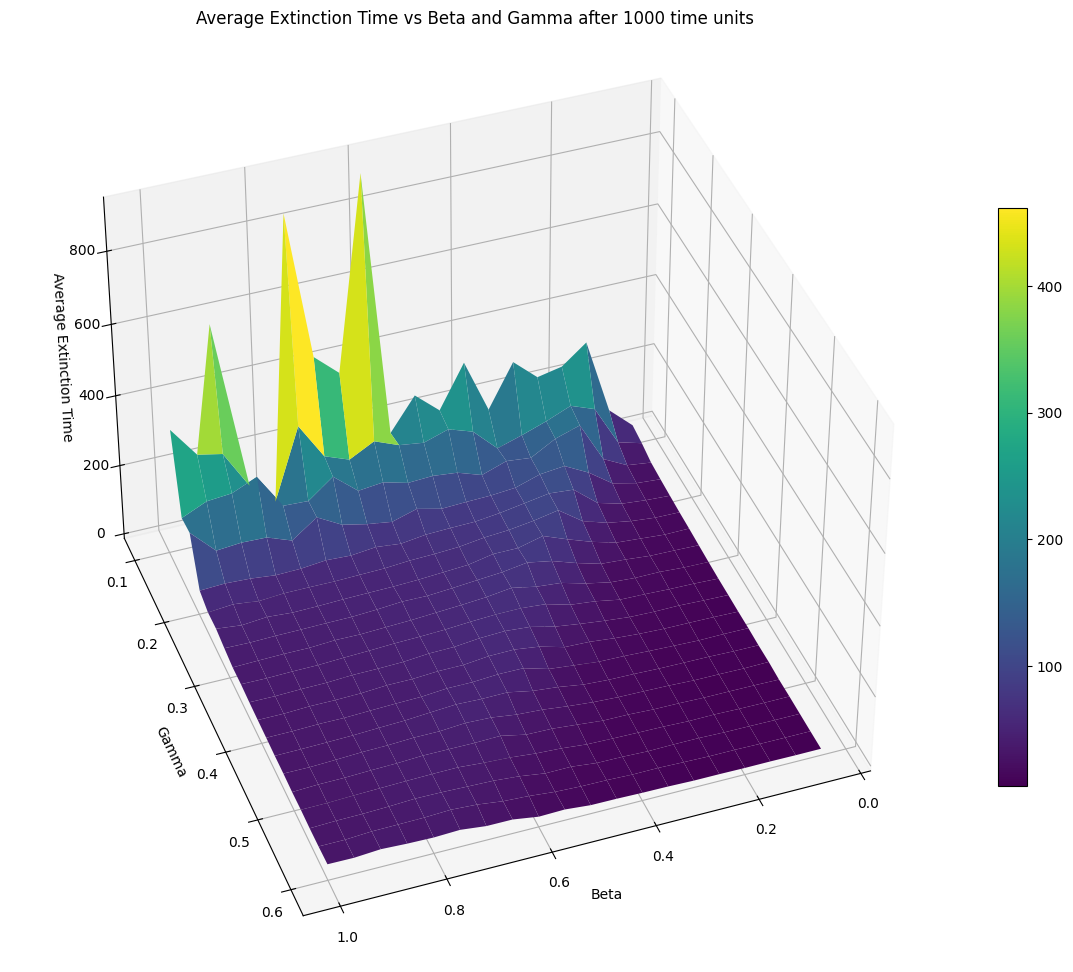

In [273]:
plot3DMesh(beta3DValues, 
            gamma3DValues,
            extinctionTimeFlat, 
            "Beta", 
            "Gamma", 
            "Average Extinction Time", 
            "Average Extinction Time vs Beta and Gamma after " 
            + str(time) 
            + " time units",
            40, 70)


#### Average Extinction Time of the average of a Number of Gillespie's Simulations for a Range of Gamma and Beta with Basic Reproductive Rate color range

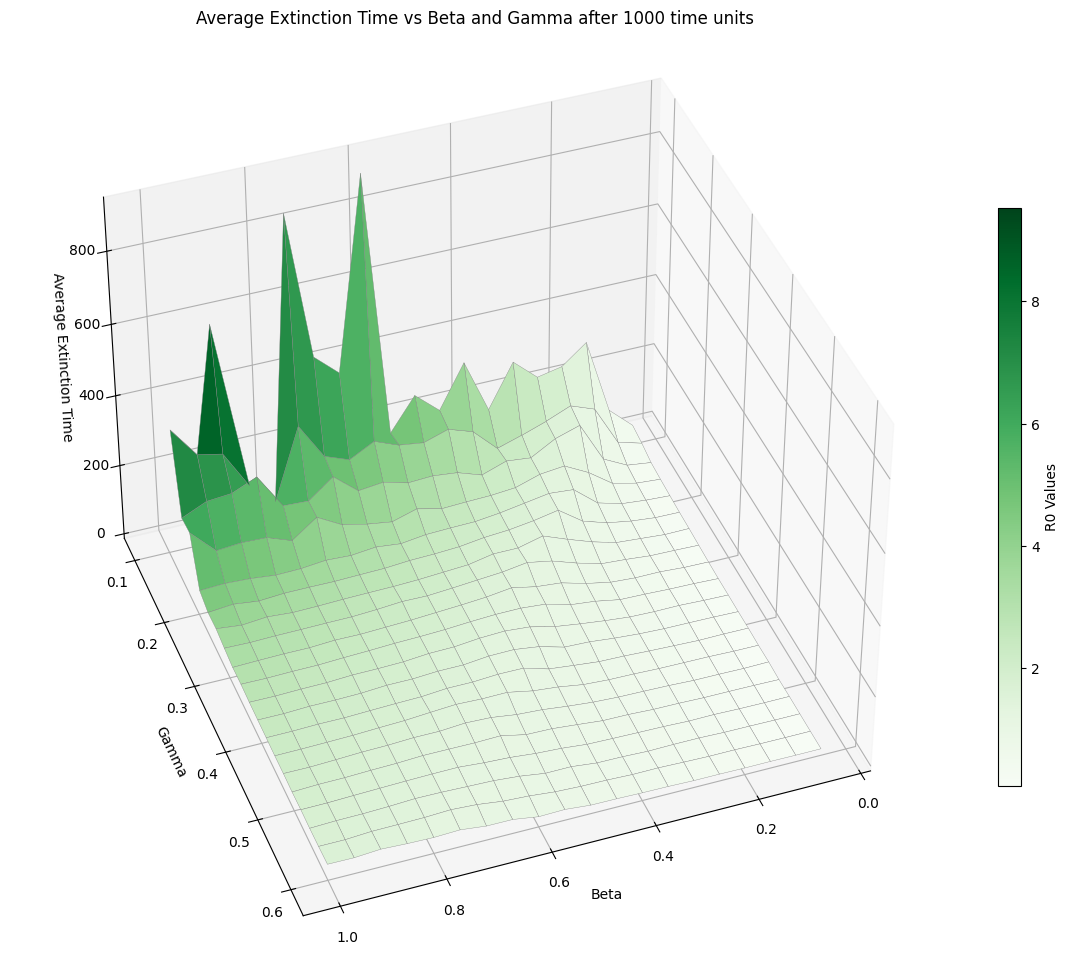

In [274]:
plot3DMesh(beta3DValues, 
            gamma3DValues,
            extinctionTimeFlat, 
            "Beta", 
            "Gamma", 
            "Average Extinction Time", 
            "Average Extinction Time vs Beta and Gamma after " 
            + str(time) 
            + " time units", 
            40, 70,
            r0Flat)

#### Basic Reproductive Rate of the average of a Number of Gillespie's Simulations for a Range of Gamma and Beta

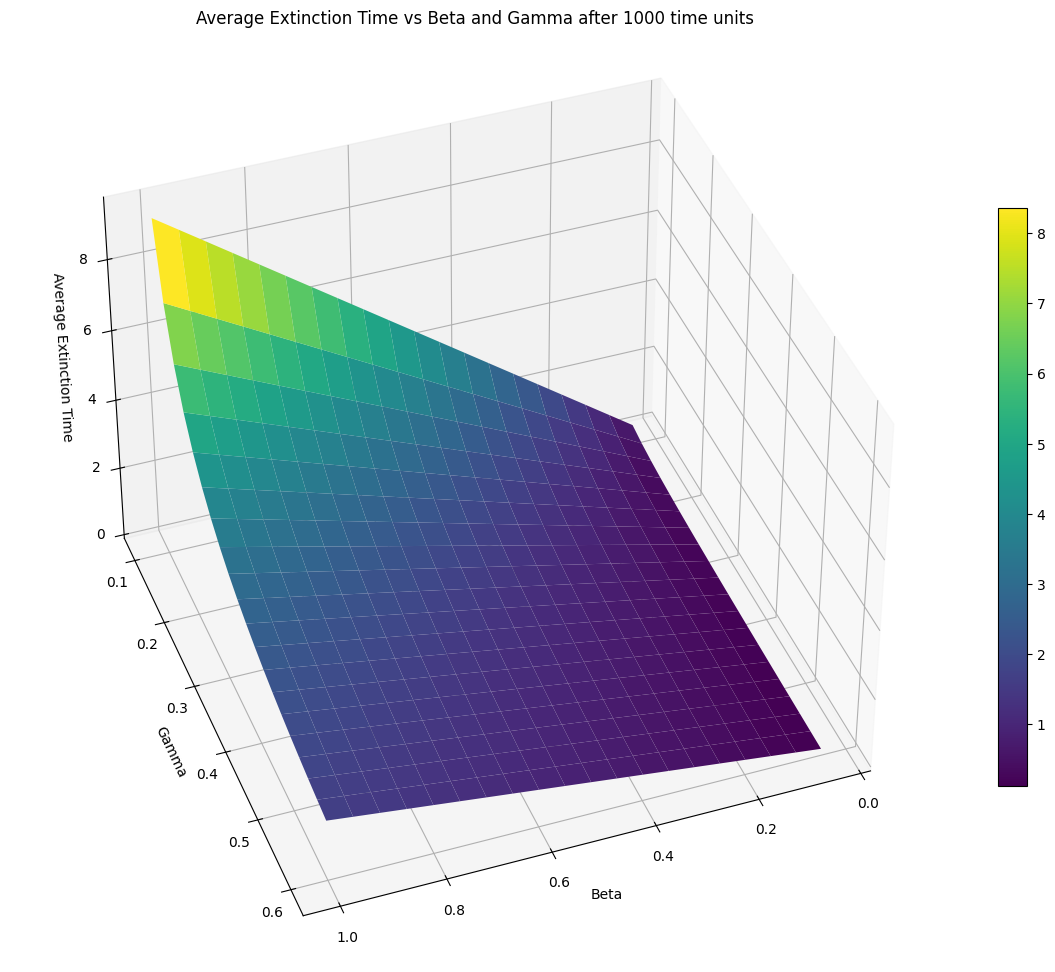

In [275]:
plot3DMesh(beta3DValues, 
            gamma3DValues,
            r0Flat, 
            "Beta", 
            "Gamma", 
            "Average Extinction Time", 
            "Average Extinction Time vs Beta and Gamma after " 
            + str(time) 
            + " time units", 
            40, 70)

#### Extinction Proportion of the average of a Number of Gillespie's Simulations for a Range of Gamma and Beta

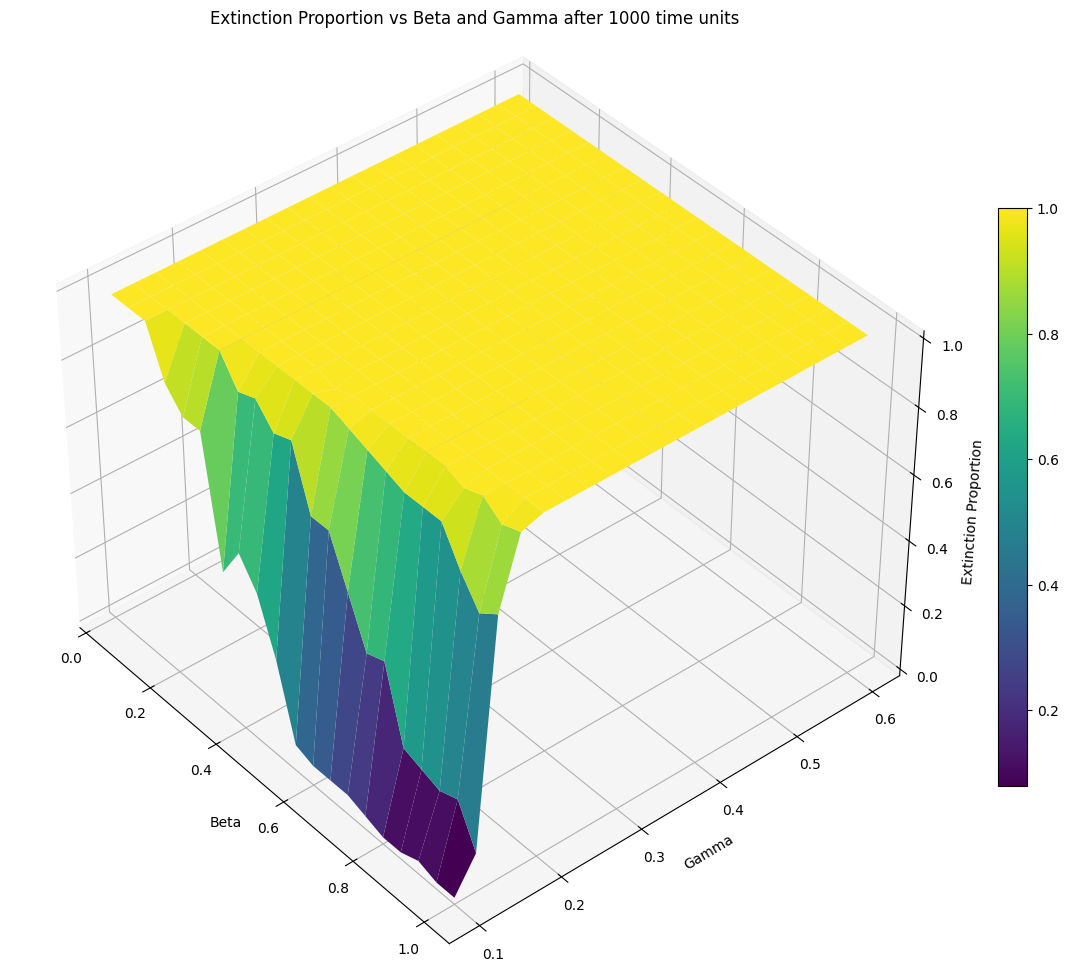

In [276]:
plot3DMesh(beta3DValues,
            gamma3DValues, 
            extinctionProportionFlat, 
            "Beta", 
            "Gamma", 
            "Extinction Proportion", 
            "Extinction Proportion vs Beta and Gamma after " 
            + str(time) 
            + " time units", 
            40, 
            320)

#### Extinction Proportion of the average of a Number of Gillespie's Simulations for a Range of Gamma and Beta with Basic Reproductive Rate color range

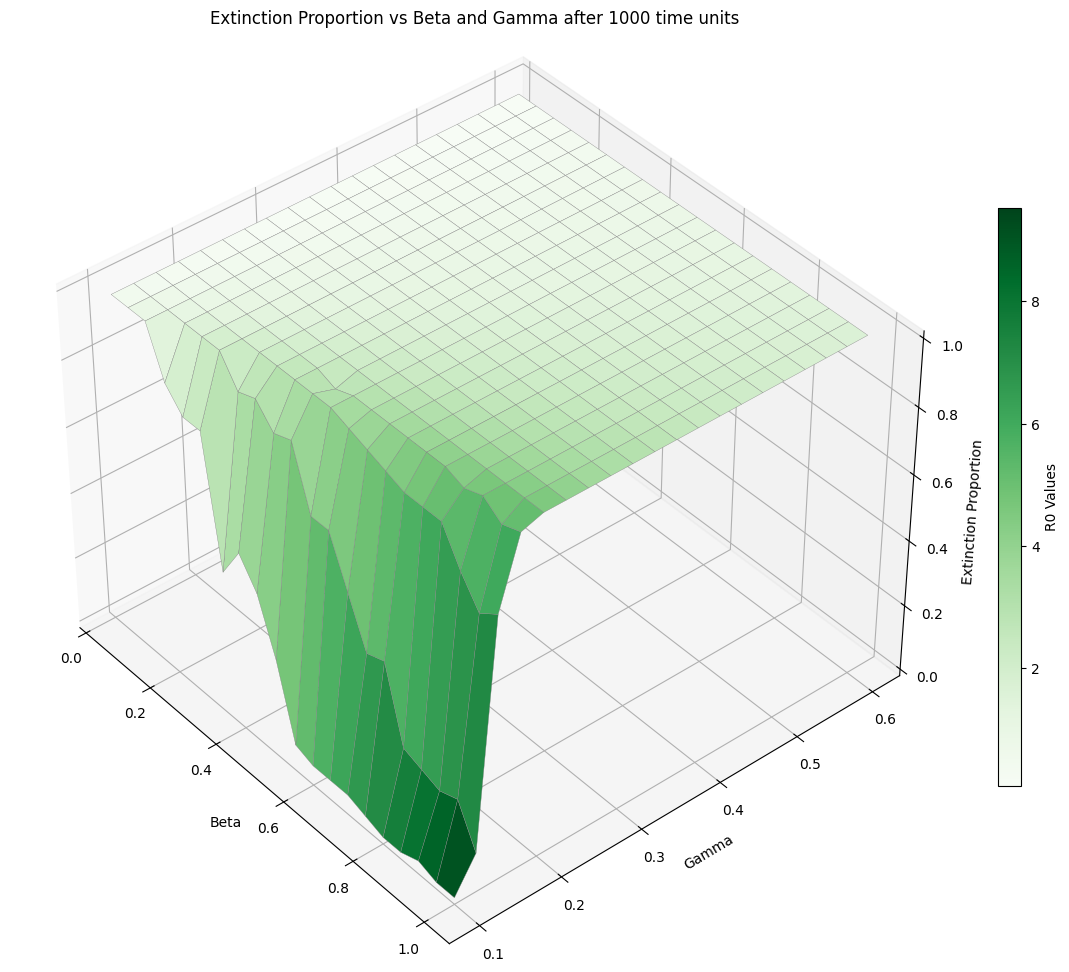

In [277]:
plot3DMesh(beta3DValues,
            gamma3DValues, 
            extinctionProportionFlat, 
            "Beta", 
            "Gamma", 
            "Extinction Proportion", 
            "Extinction Proportion vs Beta and Gamma after " 
            + str(time) 
            + " time units", 
            40, 
            320,
            r0Flat)

#### Basic Reproductive Rate of the average of a Number of Gillespie's Simulations for a Range of Gamma and Beta

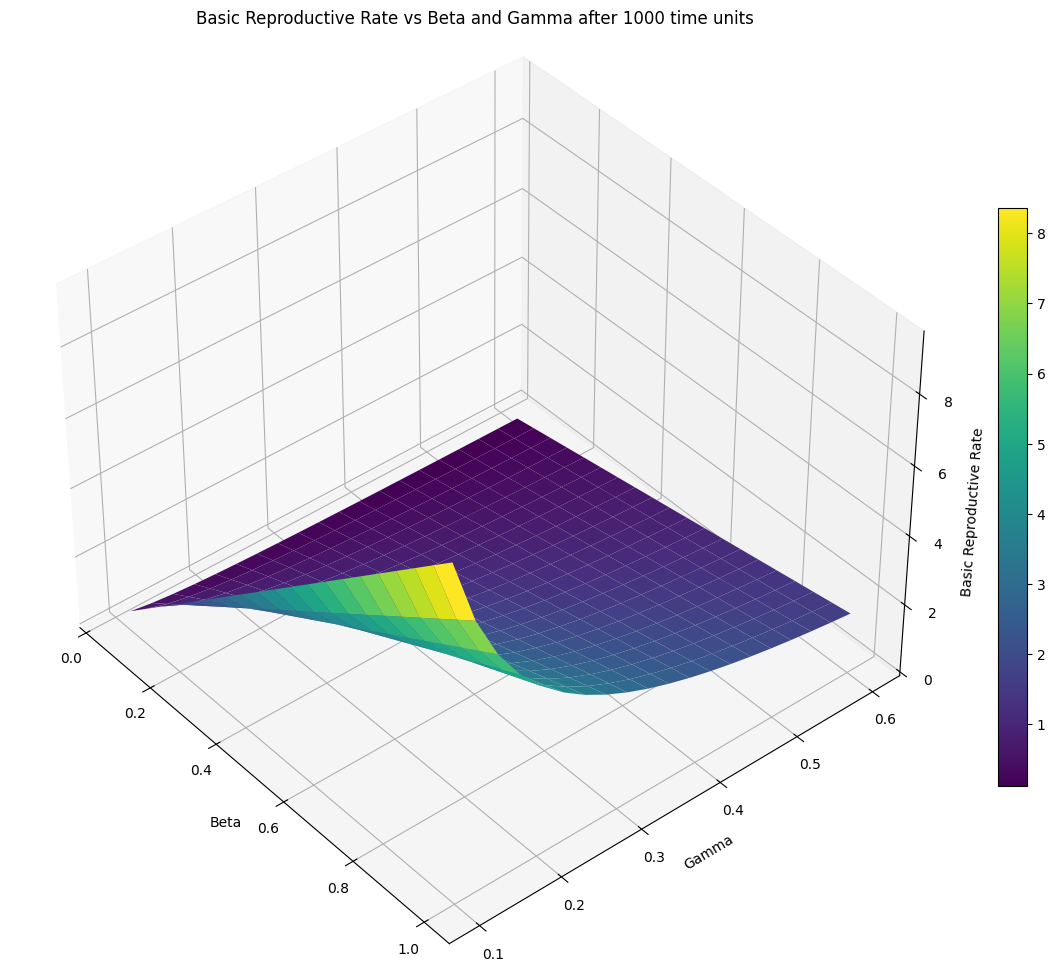

In [278]:
plot3DMesh(beta3DValues, 
            gamma3DValues,
            r0Flat, 
            "Beta", 
            "Gamma", 
            "Basic Reproductive Rate", 
            "Basic Reproductive Rate vs Beta and Gamma after " 
            + str(time) 
            + " time units", 
            40, 320)

### Critical Community Size

In [279]:
X0 = 990
Y0 = 10
Z0 = 0
N = X0 + Y0 + Z0
beta = 0.5
gamma = 0.1
mu = 0.01

In [280]:
time = 1000
timeInterval = 1

In [281]:
numRunsCCS = 50

In [282]:
maxPopulation = 1000
populationSteps = 30
populationMin = 10
#populationRange = np.linspace(populationMin, maxPopulation, populationSteps)
populationRange = np.geomspace(populationMin, maxPopulation, populationSteps)

In [283]:
betaMaxCCS = 1
betaStepsCCS = 30
betaMinCCS = betaMaxCCS / betaStepsCCS
betaRangeCCS = np.linspace(betaMinCCS, betaMaxCCS, betaStepsCCS)
#betaRangeCCS = np.geomspace(betaMinCCS, betaMaxCCS, betaStepsCCS)

In [284]:
saveModels = False

In [285]:
betaPopModels = {}
varBetaPop = {}
meansBetaPop = {}
stdDevBetaPop = {}
covBetaPopSI = {}

extTimeBetaPop = {}
extPropBetaPop = {}

for N in populationRange:
    for b in betaRangeCCS:
        X0 = N - 1
        Y0 = 1
        Z0 = 0

        # Simulate Gillespies for current beta and total population
        (betaPopModels[N, b],
        meansBetaPop[N, b], 
        varBetaPop[N, b], 
        stdDevBetaPop[N, b], 
        covBetaPopSI[N, b], 
        extTimeBetaPop[N, b], 
        extPropBetaPop[N, b]) = simulateNumGillespies(X0, Y0, Z0, 
                                                        N, 
                                                        b, 
                                                        gamma, 
                                                        mu, 
                                                        time, 
                                                        numRunsCCS,
                                                        saveModels)

In [286]:
stdDevFlatS = []
stdDevFlatI = []
stdDevFlatR = []

covarianceFlatSI = []

extinctionTimeFlat = []
extinctionProportionFlat = []

for N in populationRange:
    for b in betaRangeCCS:
        stdS, stdI, stdR = stdDevBetaPop[N, b]

        stdDevFlatS.append(stdS)
        stdDevFlatI.append(stdI)
        stdDevFlatR.append(stdR)

        covarianceFlatSI.append(covBetaPopSI[N, b])

        extinctionTimeFlat.append(extTimeBetaPop[N, b])
        extinctionProportionFlat.append(extPropBetaPop[N, b])

#### Proportion of extinctions of the average of a number of Gillespie's Simulations for a range of Beta and total Population

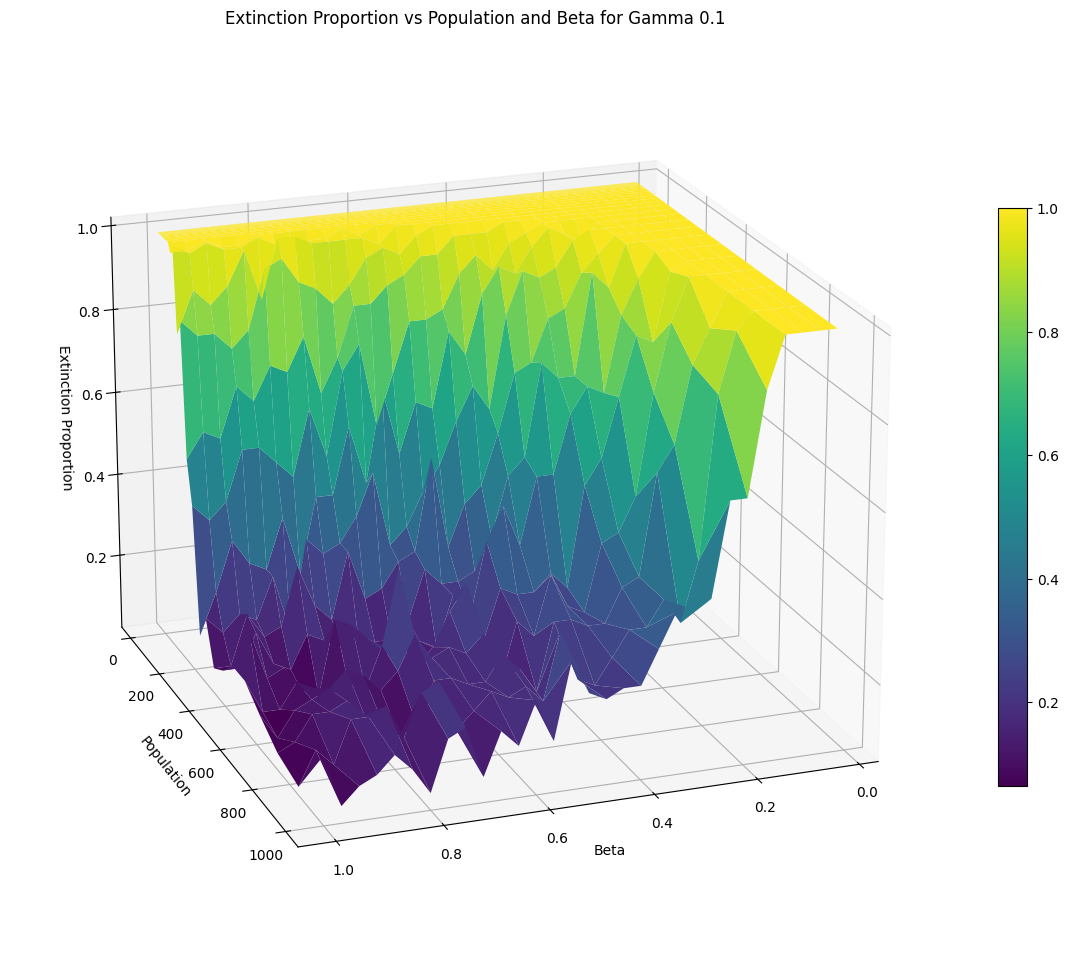

In [287]:
plot3DMesh(betaRangeCCS, 
            populationRange, 
            extinctionProportionFlat, 
            "Beta", 
            "Population", 
            "Extinction Proportion", 
            "Extinction Proportion vs Population and Beta for Gamma 0.1", 
            20, 70)

#### Average Extinction Time for the average of a number of Gillespie's Simulations for a range of Beta and total Population

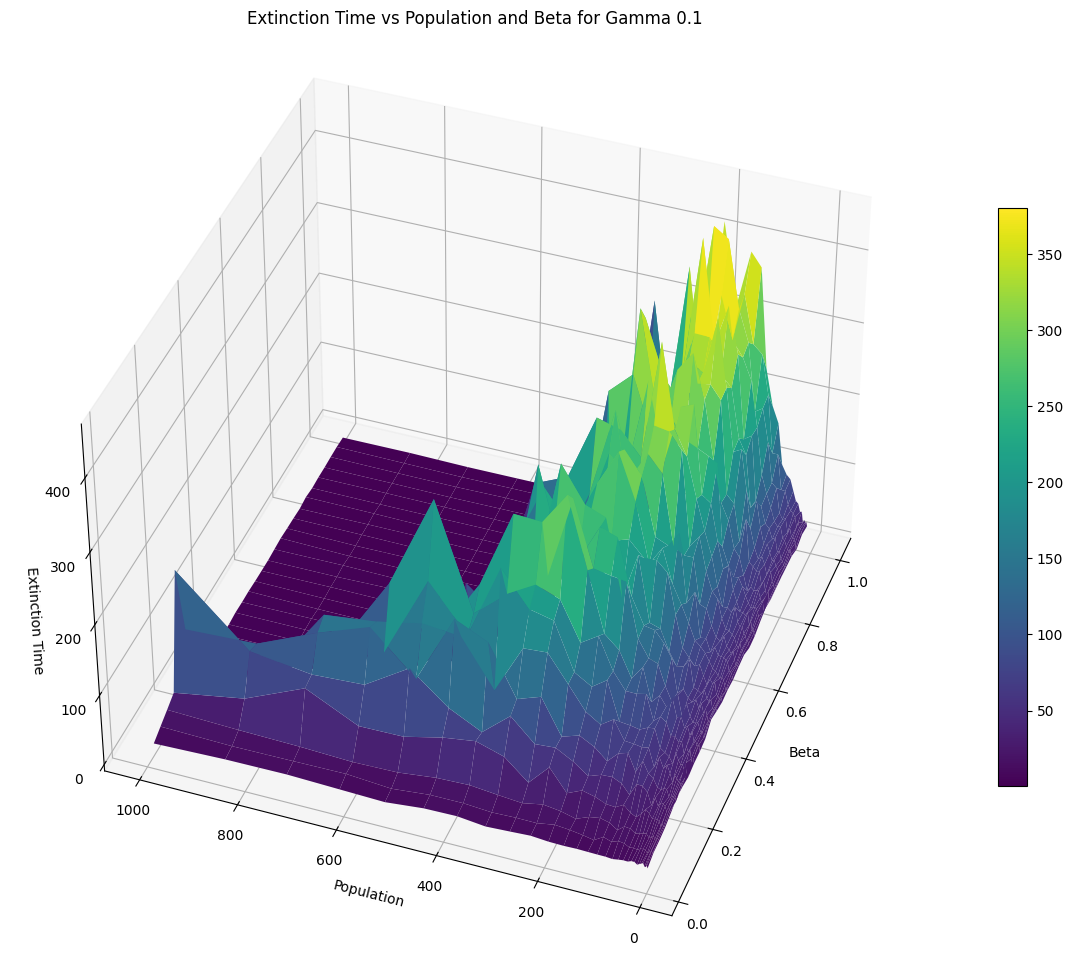

In [288]:
plot3DMesh(betaRangeCCS,
            populationRange, 
            extinctionTimeFlat, 
            "Beta", 
            "Population", 
            "Extinction Time", 
            "Extinction Time vs Population and Beta for Gamma 0.1", 
            40, 
            200)

## Problem 2: Spatial Models - Networks

In [289]:
X0 = 990
Y0 = 10
Z0 = 0
N = X0 + Y0 + Z0
beta = 0.5
gamma = 0.1
mu = 0.01

In [290]:
time = 250
timeInterval = 1

In [291]:
nodeNum = 100
edgeNum = 3

barabasiNet = nx.barabasi_albert_graph(nodeNum, edgeNum)

modelSIR = ep.SIRModel(barabasiNet)

modelConfig = mc.Configuration()
modelConfig.add_model_parameter('beta', beta)
modelConfig.add_model_parameter('gamma', gamma)
modelConfig.add_model_parameter('mu', mu)
modelConfig.add_model_initial_configuration('Susceptible', X0)
modelConfig.add_model_initial_configuration('Infected', Y0)
modelConfig.add_model_initial_configuration('Recovered', Z0)
modelSIR.set_initial_status(modelConfig)

modelIterations = modelSIR.iteration_bunch(time)

result = modelSIR.build_trends(modelIterations)

plt.figure()
for r in result:
    plt.plot(r['trends']['node_count'][0], 
             label = r['status'])

plt.xlabel('Time')
plt.ylabel('Number of Nodes')
plt.title('SIR Model on Barabási-Albert Network')
plt.legend()
plt.grid(True)
plt.show()

TypeError: 'int' object is not iterable